In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import 
import os
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
import matplotlib.pyplot as plt
from uncertainty_motion_prediction.dataloader import Dataloader
from uncertainty_motion_prediction.evaluators import DistanceErrorEvaluator
from uncertainty_motion_prediction.predictor import (
    HMMMultinomialFirstOrder, HMMLatentSegmentsExtractor, KMeansOutcome, HMMLatentSegmentsPredictor
)
from uncertainty_motion_prediction.predictor import HMMContinuousEmissionsPredictor
from hmmlearn import hmm

In [3]:
#from uncertainty_motion_prediction.predictor.hmm_continuous_emissions import normalise_segment_batch
from uncertainty_motion_prediction.predictor import normalise_segment_batch


# Load the Dataset and Overview of the Data

Load and Data and conduct some brief analysis on the pattern of the normalised segment.

In [4]:
#Switch the dataset
'''
0: eth-univ
1: eth-hotel
2: ucy-zara1
3: ucy-zara2
4: ucy-univ3
'''
dataset_no = 4

In [5]:
dataset=Dataloader();
traj_dataset = dataset.load(dataset_no)

In [6]:
segment_length = 4
num_segment = 4# Hidden Markov Model with Gaussian emissions (to model trajectory observations)

#Start by instantiating a HMM with continuous Gaussian emission distributions.
trajlets_for_hmm_learning = traj_dataset.get_trajlets(
    length =num_segment * segment_length*0.4, overlap=4, to_numpy=True
)
print(trajlets_for_hmm_learning.shape)

(1798, 16, 5)


In [7]:
trajlets_shape = trajlets_for_hmm_learning.shape
normalised = normalise_segment_batch(trajlets_for_hmm_learning[:, :, 0:4], segment_length)
sequence_lengths = np.array([num_segment for i in range(trajlets_shape[0])])



In [8]:
#take a look at the data
df = pd.DataFrame(normalised)
df.describe()

,0,1,2,3,4,5,6,7
count,7192.0,7192.000000,7192.000000,7192.000000,7192.0,7.192000e+03,7192.000000,7.192000e+03
mean,0.0,0.222243,0.428403,0.626145,0.0,-6.701371e-09,0.000401,4.639371e-04
std,0.0,0.087103,0.170643,0.256411,0.0,3.034106e-07,0.047294,1.033057e-01
min,0.0,0.000000,-0.167393,-0.392141,0.0,-2.164664e-06,-0.216102,-4.502742e-01
25%,0.0,0.164586,0.354507,0.541018,0.0,-1.461815e-07,-0.017526,-4.738719e-02
50%,0.0,0.232839,0.462405,0.689668,0.0,0.000000e+00,0.000000,8.526727e-07
75%,0.0,0.291926,0.552090,0.798821,0.0,1.288093e-07,0.017705,4.782761e-02
max,0.0,0.387877,0.688450,0.999391,0.0,2.346654e-06,0.198073,4.231603e-01


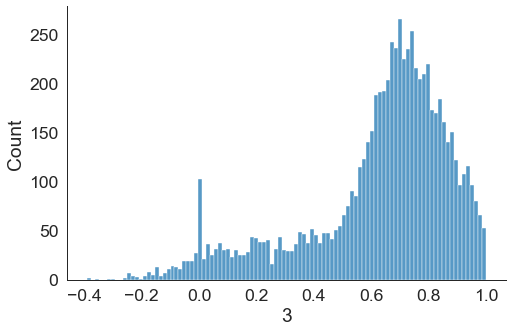

In [9]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=df, x=3, kind="hist", bins = 100, aspect = 1.5)


In [10]:
# Pair-wise Scatter Plots
#pp = sns.pairplot(df, size=1.8, aspect=1.8,
#                  plot_kws=dict(edgecolor="k", linewidth=0.5),
#                  diag_kind="kde", diag_kws=dict(shade=True))

#fig = pp.fig 
#fig.subplots_adjust(top=0.93, wspace=0.3)
#t = fig.suptitle('Wine Attributes Pairwise Plots', fontsize=14)


# Hidden Markov Model with Gaussian emissions (to model trajectory observations)

Start by instantiating a HMM with continuous Gaussian emission distributions.

In [11]:
if dataset_no == 0:
    # ETC Uni
    n_components = 10
    covariance_type = "diag"
    n_iter = 50
elif dataset_no == 1:
    # ETC Hotel
    n_components = 4
    covariance_type = "diag"
    n_iter = 50
elif dataset_no == 2:
    # ETC Hotel
    n_components = 4
    covariance_type = "diag"
    n_iter = 50
elif dataset_no == 3:
    # ETC Hotel
    n_components = 4
    covariance_type = "diag"
    n_iter = 50
elif dataset_no == 4:
    # ucy-univ3
    n_components = 4
    covariance_type = "diag"
    n_iter = 80


model = hmm.GaussianHMM(n_components=n_components, covariance_type=covariance_type, n_iter=n_iter, verbose=True)

Preprocess the trajectories by normalising them (without the adjustment on Rotation). Then we estimate the model parameters (transition matrix and Gaussian emission distribution parameters).

In [12]:
trajlets_shape = trajlets_for_hmm_learning.shape
normalised = normalise_segment_batch(trajlets_for_hmm_learning[:, :, 0:4], segment_length)
sequence_lengths = np.array([num_segment for i in range(trajlets_shape[0])])

model.fit(normalised, lengths=sequence_lengths)

         1       83594.7033             +nan
         2      151589.4828      +67994.7795
         3      154289.4347       +2699.9519
         4      154812.5077        +523.0730
         5      154927.3767        +114.8689
         6      154975.9280         +48.5514
         7      155008.3485         +32.4205
         8      155034.9453         +26.5968
         9      155058.5003         +23.5550
        10      155080.2184         +21.7181
        11      155101.0679         +20.8495
        12      155122.0322         +20.9643
        13      155144.0870         +22.0548
        14      155168.2053         +24.1183
        15      155195.4146         +27.2093
        16      155226.8356         +31.4210
        17      155263.6230         +36.7874
        18      155306.7888         +43.1658
        19      155356.9795         +50.1907
        20      155414.2287         +57.2492
        21      155477.6174         +63.3887
        22      155545.0583         +67.4409
        23

GaussianHMM(n_components=4, n_iter=80, verbose=True)

In [13]:
import pickle
with open('gaussian_hmm_%s.pkl'%dataset_no, 'wb') as file:
    pickle.dump(model, file)


In [14]:
model.transmat_

array([[3.37974284e-01, 7.49577807e-05, 3.29236030e-01, 3.32714729e-01],
       [6.08402505e-03, 2.59613339e-01, 2.25922823e-02, 7.11710354e-01],
       [1.17400494e-01, 6.49163877e-03, 4.13014219e-01, 4.63093648e-01],
       [1.33263603e-02, 1.59149399e-02, 9.44050196e-02, 8.76353680e-01]])

Set up to test the model.

In [15]:
trajlets_for_testing = traj_dataset.get_trajlets(
    length=segment_length * num_segment * 0.4,
    overlap=1,
    to_numpy=True
)
print(trajlets_for_testing.shape)

(884, 16, 5)


A sanity check for our predictor and model, to visually inspect if the predict function works and yields reasonable values.

In [16]:
traj = trajlets_for_hmm_learning[0, :, :]

In [17]:
import pickle

model = None
with open('gaussian_hmm_%s.pkl'%dataset_no, 'rb') as file:
    model = pickle.load(file)
    
predictor = HMMContinuousEmissionsPredictor(hmm = model)
print(traj.shape)
print(predictor.predict(traj))

(16, 5)
[[-0.5426586   4.934493  ]
 [-0.82268426  5.30958817]
 [-1.09388009  5.67378979]
 [-1.35509702  6.02313357]]


Compute the ADE and FDE of the model.

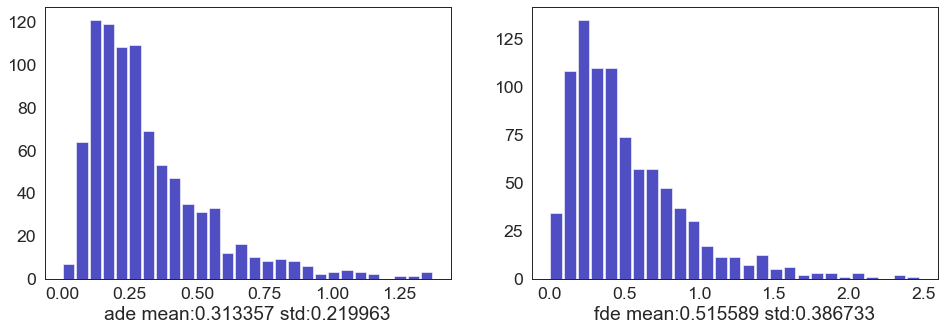

In [18]:
evaluator = DistanceErrorEvaluator(N_future=4)
evaluator.evaluate(predictor, trajlets_for_testing)
evaluator.hist()
res_state = evaluator.statistic()